# <span style="color:#065C9C">pRF fitting procedure using **Braincoder**</span>


In [ ]:
# Define subjects to process
#subject_ids = ['02', '03', '05']
subject_ids = ['02']
session_id = 'ses-01'

# Data source configuration
data_source = 'remote'  # Change this to 'local' or 'remote'

projType = 'surf-projected_projfrac'
#projType = 'surf-projected_projdist-avg' 

# Define paths based on data source
if data_source == 'local':
    base_data_path = '/media/user/External/XY/'
    pRF_images_path = '/home/user/Documents/data/XY/pRF_images/'
elif data_source == 'remote':
    base_data_path = '/media/user/Crucial/XY/'
    pRF_images_path = '/media/user/Crucial/XY/pRF_images'
else:
    raise ValueError("data_source must be either 'local' or 'remote'")



# for fMRI data manipulation and basic data handling
import os
import sys
import glob
import math 
import numpy as np
import scipy.stats as stats
import pandas as pd
import nibabel as nib
import neuropythy as ny  
import ipyvolume as ipv
from PIL import Image
import matplotlib.pyplot as plt


# for pRF modeling
from numba import cuda 
device = cuda.get_current_device()
device.reset()

import os
import tensorflow as tf

# Set this flag to False to use CPU instead of GPU
USE_GPU = True

if not USE_GPU:
    # Force TensorFlow to use CPU
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    print("Running on CPU")
else:
    # Configure GPU memory growth to avoid memory issues
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            # Use async memory allocator for better memory management
            os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
            print(f"Running on GPU: {gpus}")
        except RuntimeError as e:
            print(f"GPU configuration error: {e}")
    else:
        print("No GPU devices found, falling back to CPU")
        os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Verify current device being used
print(f"TensorFlow is using: {tf.config.get_visible_devices()}")
print(f"Built with CUDA: {tf.test.is_built_with_cuda()}")



from braincoder.models import GaussianPRF2DWithHRF
from braincoder.hrf import SPMHRFModel
from braincoder.optimize import ParameterFitter

## For pRF map plotting
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Wedge
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors

# Retmaps code
from cfmap.color_palettes import get_color_palettes
from cfmap.pRF_processing import plot_prf_histograms, plot_roi_retMap


# Load color palettes
color_palettes = get_color_palettes()
color_palettes = get_color_palettes()
colors_ecc = color_palettes["eccentricity"]
colors_polar = color_palettes["polar"]


# Create save path
base_save_path = os.path.join(base_data_path, 'pRF_results', projType)
os.makedirs(base_save_path, exist_ok=True)


# Create and visualize stimuli
data_list = [] # Initialize an empty list to store the data

# Loop through the files in the folder
for frame in range(150):
    # Load the .png file
    file_path = os.path.join(pRF_images_path,'run5_' + str(frame) + '.png')
    image = Image.open(file_path)
    data = np.array(image)
    data_list.append(data)

# Stack the data along the third dimension to create the design matrix
design_matrix = np.stack(data_list, axis=-1)

print(f'design matrix shape: {design_matrix.shape}')



# screen pRF stimulus parameters
screen_height_cm   = 69.4# 32 #39.29 #69.84 #12.65
screen_size_cm     = screen_height_cm/2 
screen_distance_cm = 199 #5.0

# calculate max stim ecc
max_ecc = math.atan(screen_size_cm/screen_distance_cm)

print('max ecc in rad: ', max_ecc)
max_ecc_deg        = round(math.degrees(max_ecc))
print('max ecc in deg: ', max_ecc_deg)
screen_size_deg = max_ecc_deg
paradigm = np.transpose(design_matrix, (2, 0, 1))

x, y = np.meshgrid(np.linspace(-screen_size_deg/2, screen_size_deg/2, paradigm.shape[1]),
                    np.linspace(-screen_size_deg/2, screen_size_deg/2, paradigm.shape[2]))

grid_coordinates = pd.DataFrame(np.array([x.flatten(), y.flatten()]).T.astype(np.float32), columns=["x", "y"])
print(f"paradigm shape: {paradigm.shape}")

def make_grid_parameters(min_ecc: float = 0.1,
                     max_ecc: float = 11,
                     min_size: float = 0.1,
                     max_size: float = 5,
                     nr_of_points: int = 40,):
    ecc = np.linspace(np.sqrt(min_ecc), np.sqrt(max_ecc), nr_of_points//2)**2
    sizes = np.linspace(min_size, max_size, nr_of_points)
    x = np.concatenate((-ecc[::-1], ecc))

    return {'x':x, 'y':x, 'size':sizes}

Running on GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow is using: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Built with CUDA: True
design matrix shape: (150, 150, 150)
max ecc in rad:  0.17263612599950473
max ecc in deg:  10
paradigm shape: (150, 150, 150)


### Load data and atlases for a single participant

In [5]:
subject_id = subject_ids[0]
session_id = 'ses-01'



# Setup paths
subject_session_name = f"sub-{subject_id}_{session_id}"
fs_subject_path = os.path.join(base_data_path, subject_session_name, f"{subject_session_name}_iso")
surf_atlas_path = os.path.join(fs_subject_path, "surf")
save_path = os.path.join(base_data_path, subject_session_name)
pRF_params_path = os.path.join(base_data_path, 'pRF_results', projType, f"sub-{subject_id}")

# Load necessary data
v1_centers = np.load(os.path.join(save_path, "v1_centers.npy"), allow_pickle=True).item()
v1_rights = np.load(os.path.join(save_path, "v1_rights.npy"), allow_pickle=True).item()

# Create subject and flatmaps
sub = ny.freesurfer_subject(fs_subject_path)
map_projs = {h: ny.map_projection(chirality=h, 
                                center=v1_centers[h],
                                center_right=v1_rights[h],
                                method='orthographic',
                                radius=np.pi/2,
                                registration='native') 
                for h in ['lh', 'rh']}
flatmaps = {h: mp(sub.hemis[h]) for h, mp in map_projs.items()}



### Then we narrow down the vertices to just one hemisphere (and optionally to an ROI using the occipital atlas)

h = 'lh'  # Change this to 'lh' or 'rh' as needed

# Get cortex index
cortex_index = flatmaps[h].prop('index')

# Load atlas maps
varea_map = nib.freesurfer.io.read_morph_data(
    os.path.join(surf_atlas_path, f'{h}.benson14_varea.curv'))[cortex_index]
sigma_map = nib.freesurfer.io.read_morph_data(
    os.path.join(surf_atlas_path, f'{h}.benson14_sigma.curv'))[cortex_index]
benson_eccen = nib.freesurfer.io.read_morph_data(
    os.path.join(surf_atlas_path, f'{h}.benson14_eccen.curv'))[cortex_index]
benson_polar = nib.freesurfer.io.read_morph_data(
    os.path.join(surf_atlas_path, f'{h}.benson14_angle.curv'))[cortex_index]
wang15_map = nib.freesurfer.io.read_morph_data(
    os.path.join(surf_atlas_path, f'{h}.wang15.curv'))[cortex_index]

### Select small atlas-based ROI to test the pRF fitting workflow 

Number of source vertices: 863


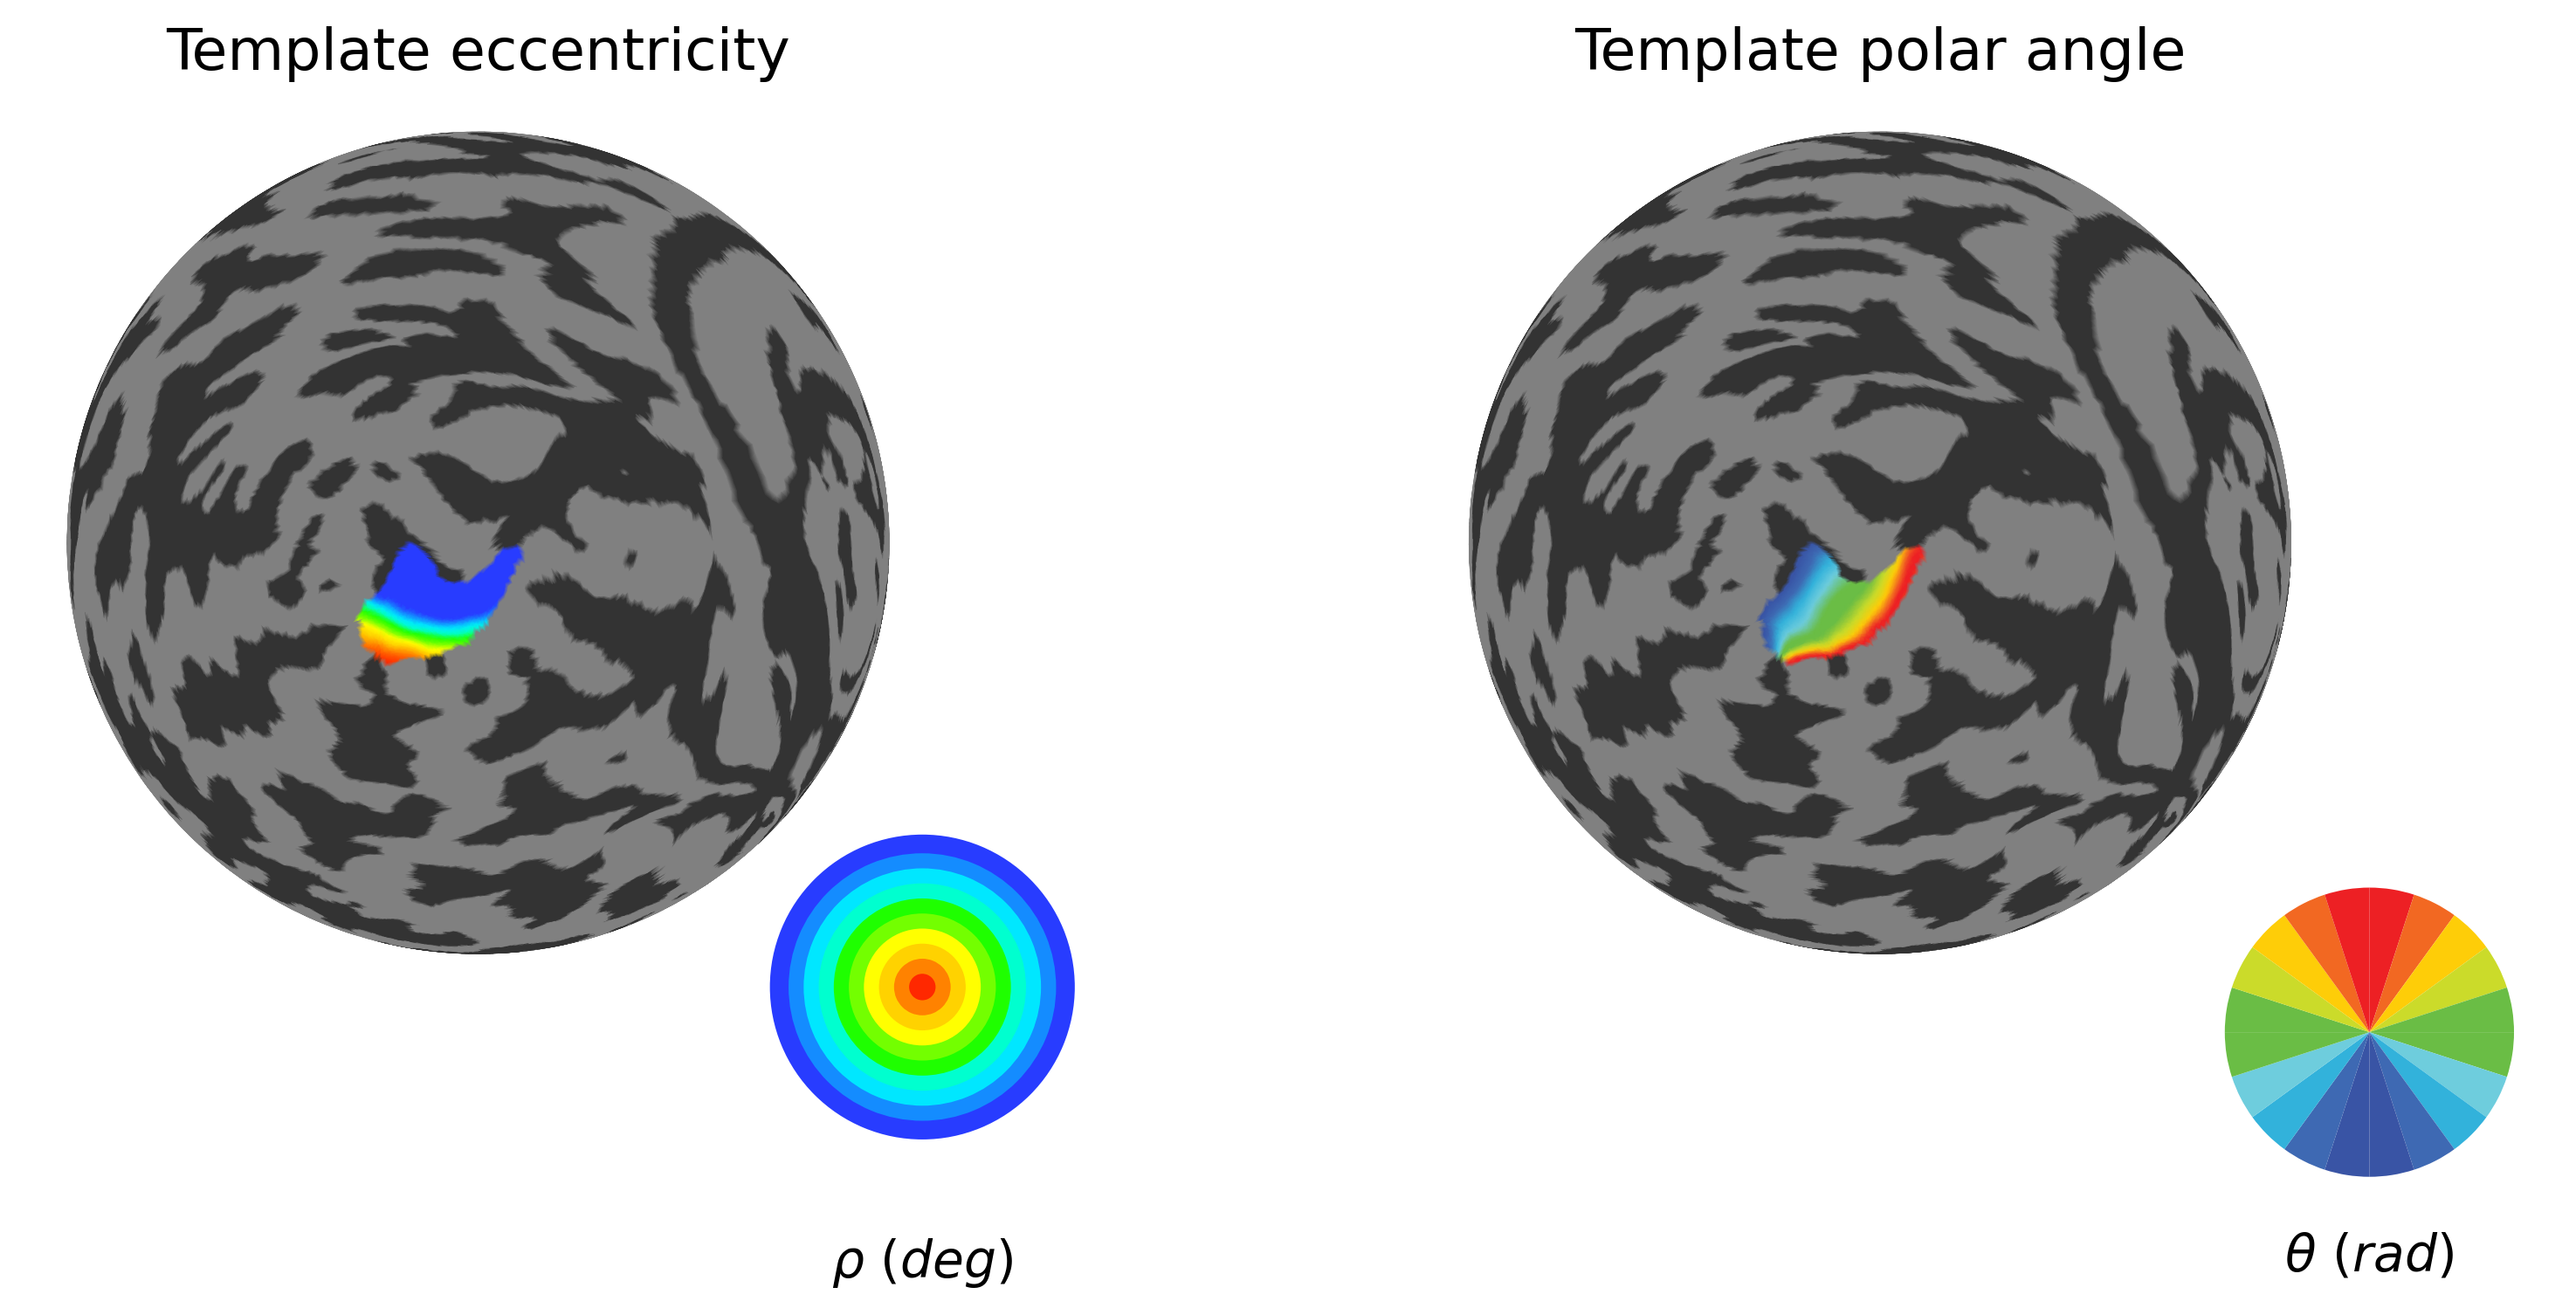

In [17]:
# Select source ROI and mask  
roi_selection=[1]

#ecc_range=(0.75, 6.75)
ecc_range=(0, 6.5)



# Create mask for V1 (regions 0 and 1 in Wang atlas)
roi_mask = np.isin(wang15_map, [1, 2])  # V1v and V1d

## Use Benson eccentricity to narrow down the source ROI extent
param_mask = (benson_eccen > ecc_range[0]) & (benson_eccen < ecc_range[1])
pol_mask =  (benson_polar >= 35) & (benson_polar <= 135)
source_mask = roi_mask & param_mask & pol_mask


# Extract ROI submesh (and update vertex indices)
roi_submesh = flatmaps[h].submesh(source_mask)
roi_submesh.prop('index')
submesh_labels = roi_submesh.prop('label')
sub_source_mask = np.isin(flatmaps[h].labels, submesh_labels)



# Get the exact indices of your source vertices
source_indices = np.where(sub_source_mask)[0]
print(f"Number of source vertices: {len(source_indices)}")

### V1 reference retinotopy from Benson atlas
plot_roi_retMap(benson_eccen, benson_polar, sub_source_mask, ['Template eccentricity', 'Template polar angle'], flatmaps, colors_ecc, colors_polar, h)




### Load training data and test the workflow

In [16]:
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

# Load time series data
ts_path = os.path.join(pRF_params_path, f'{h}_averaged_cleaned_zscored.npy')

time_series = np.nan_to_num(np.load(ts_path))

train_data = time_series[sub_source_mask].T


del time_series

train_data.shape

(150, 863)

In [18]:
###### pRF modeling #######

hrf_model = SPMHRFModel(tr=2, delay=4.5, dispersion=0.75)


model_gauss = GaussianPRF2DWithHRF(data=train_data,
                                    paradigm=paradigm,
                                    hrf_model=hrf_model,
                                    grid_coordinates=grid_coordinates)

###### Grid search #######

grid_min_ecc = 0.1
grid_max_ecc = 8
grid_min_sigma = 0.1
grid_max_sigma = 5
nr_of_gridfit_points = 20

grid_parameters = make_grid_parameters(min_ecc=grid_min_ecc,
                                            max_ecc=grid_max_ecc,
                                            min_size=grid_min_sigma,
                                            max_size=grid_max_sigma,
                                            nr_of_points=nr_of_gridfit_points)

par_fitter = ParameterFitter(model=model_gauss, data=train_data, paradigm=paradigm)

baseline = [0.0]
amplitude = [1.0]

pars_gauss_grid = par_fitter.fit_grid(grid_parameters['x'],
                                        grid_parameters['y'],
                                        grid_parameters['size'],
                                        baseline,
                                        amplitude,
                                        correlation_cost=True)



###### Iterarive search (gtradient descent) #######

positive_amplitude = True
min_n_iterations = 400
max_n_iterations = 2000

# Fit baseline and amplitude

pars_gauss_ols = par_fitter.refine_baseline_and_amplitude(pars_gauss_grid,
                                                            positive_amplitude=positive_amplitude)
pars_gauss_gd = par_fitter.fit(init_pars=pars_gauss_ols,
                                min_n_iterations=min_n_iterations,
                                max_n_iterations=max_n_iterations)


# Now fit the pRF (2D Gaussian)
model_hrf = GaussianPRF2DWithHRF(data=train_data,
                                    paradigm=paradigm,
                                    hrf_model=hrf_model,
                                    grid_coordinates=grid_coordinates,
                                    flexible_hrf_parameters=True)

par_fitter_hrf = ParameterFitter(model=model_hrf, data=train_data, paradigm=paradigm)

# Then fit the HRF
# We set hrf_delay and hrf_dispersion to standard values
pars_gauss_gd['hrf_delay'] = 4.5
pars_gauss_gd['hrf_dispersion'] = 0.75

pars_gauss_hrf = par_fitter_hrf.fit(init_pars=pars_gauss_gd,
                                    min_n_iterations=min_n_iterations,
                                    max_n_iterations=max_n_iterations)

pars_gauss_hrf['r2'] = par_fitter_hrf.get_rsq(pars_gauss_hrf)



Working with chunk size of 5149


2025-10-16 14:21:27.666564: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-16 14:21:27.670198: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-16 14:21:27.673026: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

  0%|          | 0/2 [00:00<?, ?it/s]

2025-10-16 14:21:30.711591: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


*** Fitting: ***
 * x
 * y
 * sd
 * baseline
 * amplitude
Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 863


Current R2: 0.50381/Best R2: 0.50381: 100%|██████████| 2000/2000 [02:04<00:00, 16.02it/s]


*** Fitting: ***
 * x
 * y
 * sd
 * baseline
 * amplitude
 * hrf_delay
 * hrf_dispersion
Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 863


  0%|          | 0/2000 [00:00<?, ?it/s]

(1, 150, 863) (16, 863)


Current R2: 0.70904/Best R2: 0.70904: 100%|██████████| 2000/2000 [02:11<00:00, 15.20it/s]


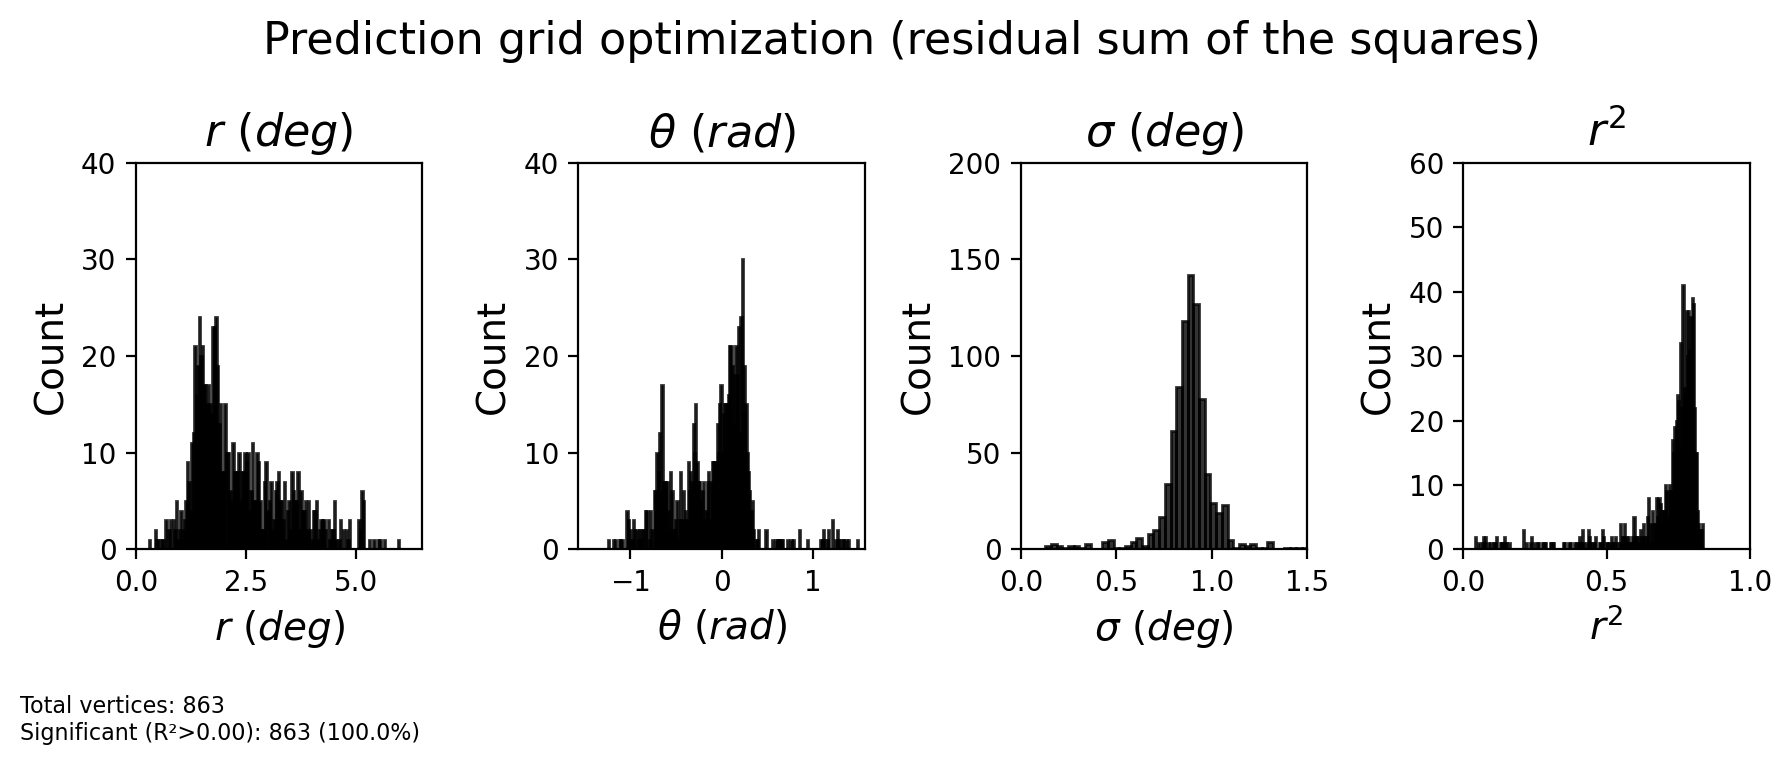

In [31]:
x = pars_gauss_hrf['x']
y = pars_gauss_hrf['y']
sigma = pars_gauss_hrf['sd']
r2 = pars_gauss_hrf['r2']
baseline = pars_gauss_hrf['baseline']
amplitude = pars_gauss_hrf['amplitude']
hrf_delay = pars_gauss_hrf['hrf_delay']
hrf_dispersion = pars_gauss_hrf['hrf_dispersion']


# Calculate derived measures
ecc = np.abs(x + 1j*y)
polar = np.angle(x + 1j*y)



fig = plot_prf_histograms(
    ecc, polar, sigma, r2,
    bins=[200, 200, 200, 200],
    ylims=[(0, 40), (0, 40), (0, 200), (0, 60)],
    xlims=[(ecc_range[0], ecc_range[1]), (-np.pi/2, np.pi/2), (0, 1.5), (0, 1)],
    r2_threshold=0.0
)
plt.suptitle('Prediction grid optimization (residual sum of the squares)', fontsize=16, y=1.1)
plt.show()


Sigma range (masked): 0.13 - 6.09


(-109.99794425569995,
 109.99814256987429,
 -109.99803380586756,
 109.99833891072826)

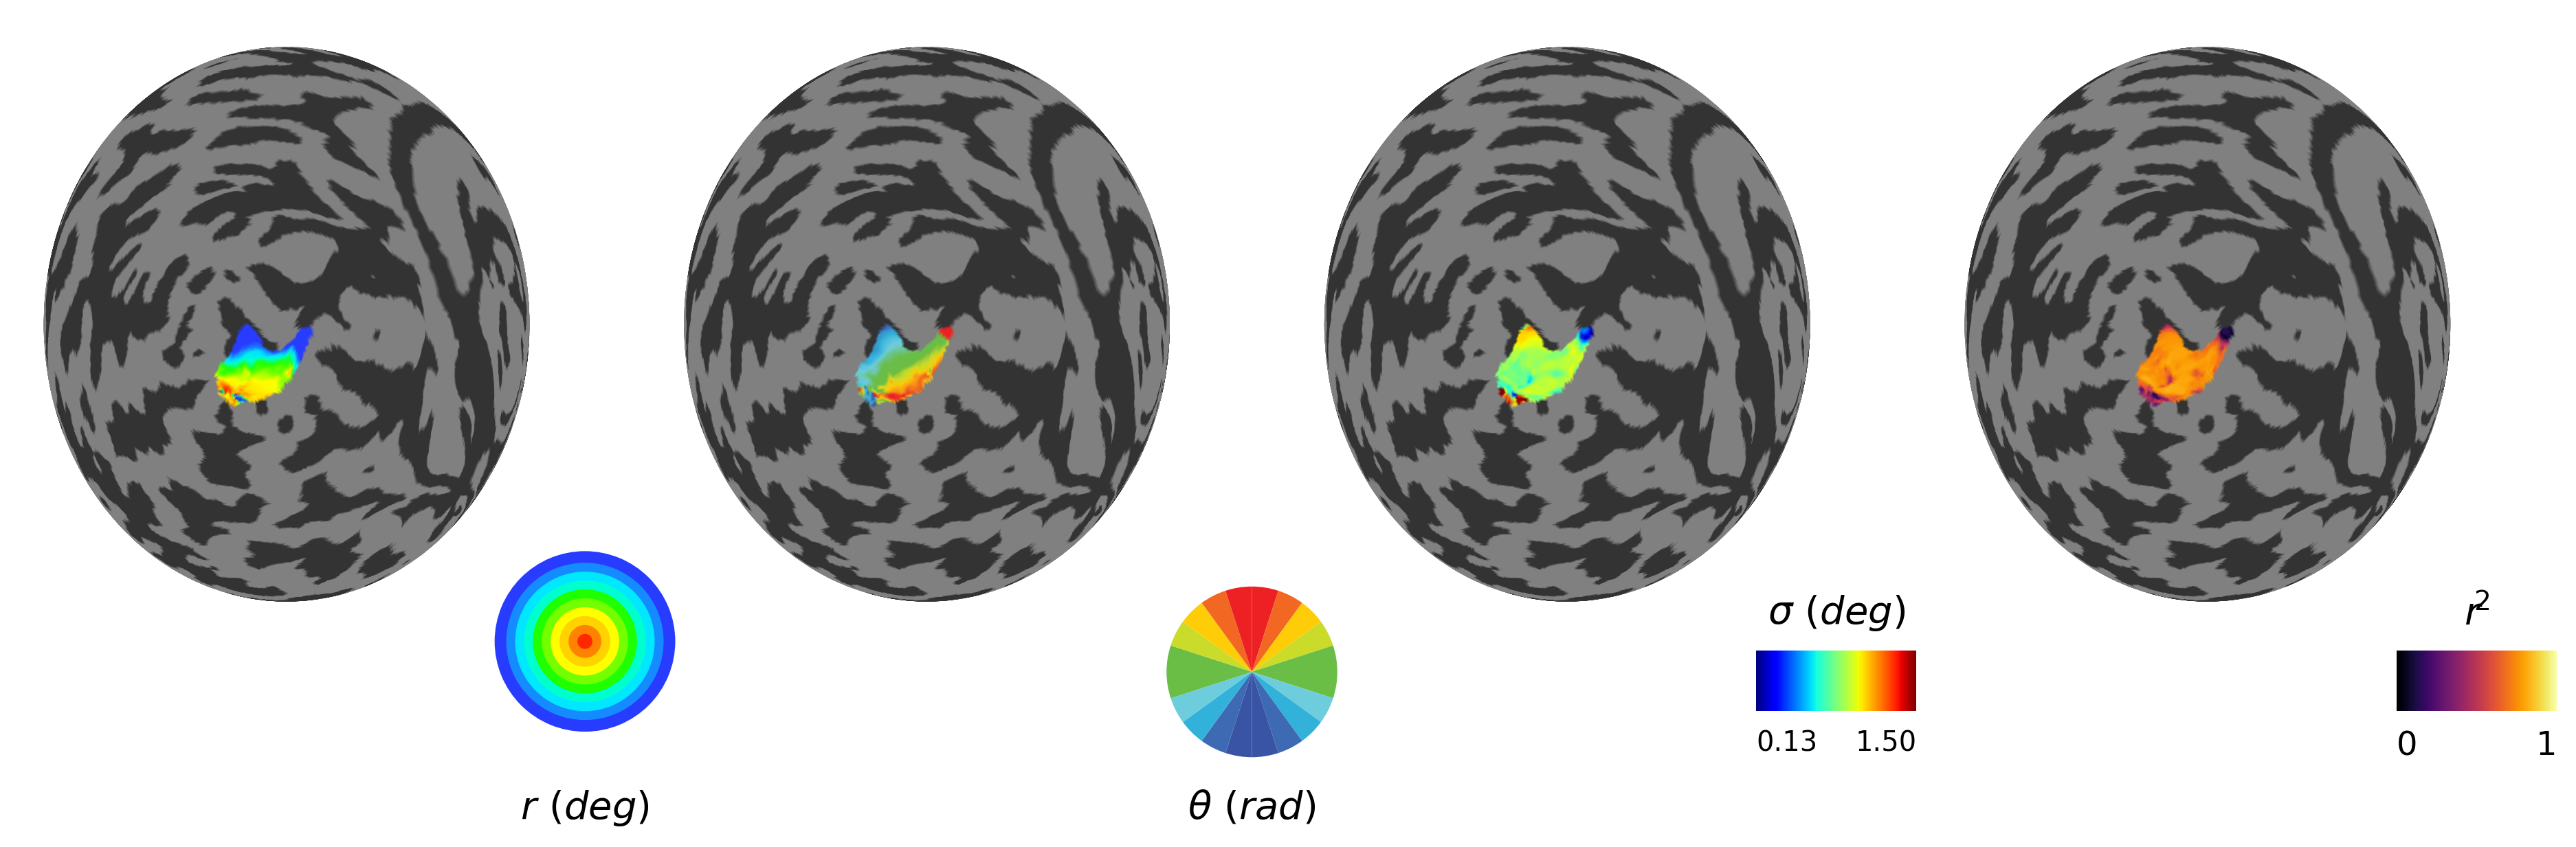

In [33]:
## Plot pRF maps (eccentricity, polar angle, sigma and residual sum of the squares)

(fig, (left_ax, left_middle_ax, right_middle_ax, right_ax)) = plt.subplots(1, 4, figsize=(16, 4), dpi=72*4)

ecc_map = np.full(len(varea_map), np.nan)
ecc_map[sub_source_mask] = ecc
polar_map = np.full(len(varea_map), np.nan)
polar_map[sub_source_mask] = polar
sigma_map = np.full(len(varea_map), np.nan)
sigma_map[sub_source_mask] = sigma
r2_map = np.full(len(varea_map), np.nan)
r2_map[sub_source_mask] = r2


# Eccentricity
ny.cortex_plot(
    flatmaps[h],
    axes=left_ax,
    color=ecc_map,
    cmap=colors_ecc['matplotlib_cmap'],
    mask=sub_source_mask,
    vmin=np.min(ecc_map[sub_source_mask]),
    vmax=np.max(ecc_map[sub_source_mask])/2
)

# Polar angle
ny.cortex_plot(
    flatmaps[h],
    axes=left_middle_ax,
    color=polar_map,
    cmap=colors_polar['matplotlib_cmap'],
    mask=sub_source_mask
)

# Sigma (pRF size)
size_vmin = np.min(sigma_map[sub_source_mask])
size_vmax = np.max(sigma_map[sub_source_mask])
print(f"Sigma range (masked): {size_vmin:.2f} - {size_vmax:.2f}")


sigma_max = 1.5
size_cmap = plt.cm.jet
m_sigma = ny.cortex_plot(
    flatmaps[h],
    axes=right_middle_ax,
    color=sigma_map,
    cmap=size_cmap,
    mask=sub_source_mask,
    vmin=np.min(sigma_map[sub_source_mask]),
    vmax=sigma_max #np.max(sigma_map[sub_source_mask])
)

# Variance explained
varex_cmap = plt.cm.inferno

m_varex = ny.cortex_plot(
    flatmaps[h],
    axes=right_ax,
    color=r2_map,
    cmap=varex_cmap,
    mask=sub_source_mask,
    vmin=0,
    vmax=1
)


# Legends/Inserts

# Eccentricity inset (concentric rings)
ecc_inset = inset_axes(
    left_ax,
    width="50%",
    height="50%",
    loc="lower right",
    borderpad=-6
)

ecc_inset.set_aspect('equal')
ecc_inset.set_xlim(-1.5, 1.5)
ecc_inset.set_ylim(-1.5, 1.5)
ecc_inset.text(0.5, -0.05, r'$\mathit{r}\ (\mathit{deg})$', ha='center', va='top', fontsize=14, transform=ecc_inset.transAxes)
ecc_inset.set_axis_off()



num_ecc_colors = len(colors_ecc["hex"])
for i, color in enumerate(colors_ecc["hex"]):
    inner_r = i / num_ecc_colors
    outer_r = (i + 1) / num_ecc_colors
    ring = Wedge((0, 0), outer_r, 0, 360,
                    width=outer_r - inner_r,
                    color=color)
    ecc_inset.add_patch(ring)




# Polar angle inset (pie)
polar_inset = inset_axes(
    left_middle_ax,
    width="40%",
    height="40%",
    loc="lower right",
    borderpad=-6
)


polar_inset.set_aspect('equal')
polar_inset.set_axis_off()
polar_inset.pie(
    [1]*len(colors_polar["hex"]),
    colors=colors_polar["hex"],
    startangle=180,
    counterclock=False
)

polar_inset.text(0.5, -0.05, r'$\theta\ (\mathit{rad})$', ha='center', va='top', fontsize=14, transform=polar_inset.transAxes)


# Sigma colorbar (standard scalar bar)
# Create a gradient rectangle

sigma_rect_ax = inset_axes(
    right_middle_ax,
    width="30%",
    height="10%",
    loc="lower right", 
    borderpad=-3
)

gradient = np.linspace(0, 1, 256).reshape(1, -1)
gradient = np.vstack((gradient, gradient))

sigma_rect_ax.imshow(gradient, aspect='auto', cmap=size_cmap, extent=[0, 1, 0, 1])

#Add labels
sigma_rect_ax.text(0, -0.3, f'{np.min(sigma_map[sub_source_mask]):.2f}', ha='left', va='top', fontsize=10)
sigma_rect_ax.text(1, -0.3, f'{sigma_max:.2f}', ha='right', va='top', fontsize=10)
sigma_rect_ax.text(0.5, 1.3, r'$\sigma\ (\mathit{deg})$', ha='center', va='bottom', fontsize=14, transform=sigma_rect_ax.transAxes)
sigma_rect_ax.axis('off')

# Varex colorbar (standard scalar bar)
varex_rect_ax = inset_axes(
    right_ax,
    width="30%",
    height="10%",
    loc="lower right",          
    borderpad=-3
)

# Create gradient image
varex_rect_ax.imshow(gradient, aspect='auto', cmap=varex_cmap,
                        extent=[0, 1, 0, 1])
# Add labels
varex_rect_ax.text(0, -0.3, '0', ha='left', va='top', fontsize=12)
varex_rect_ax.text(1, -0.3, '1', ha='right', va='top', fontsize=12)
varex_rect_ax.text(0.5, 1.3, r'$\mathit{r}\!{}^2$', ha='center', va='bottom', fontsize=14, transform=varex_rect_ax.transAxes)
varex_rect_ax.axis('off')


# Clean axes
left_ax.axis('off')
left_middle_ax.axis('off')
right_middle_ax.axis('off')
right_ax.axis('off')

### How do empirical and atlas based retinotopic map for the source ROI (V1) compare?


Pearson's rho (p-value) :  0.7484027220662547 ( 1.049164494247849e-155 )

Circular rho  (p-value) :  0.8231299928912087 ( 1.07090993936731e-127 )


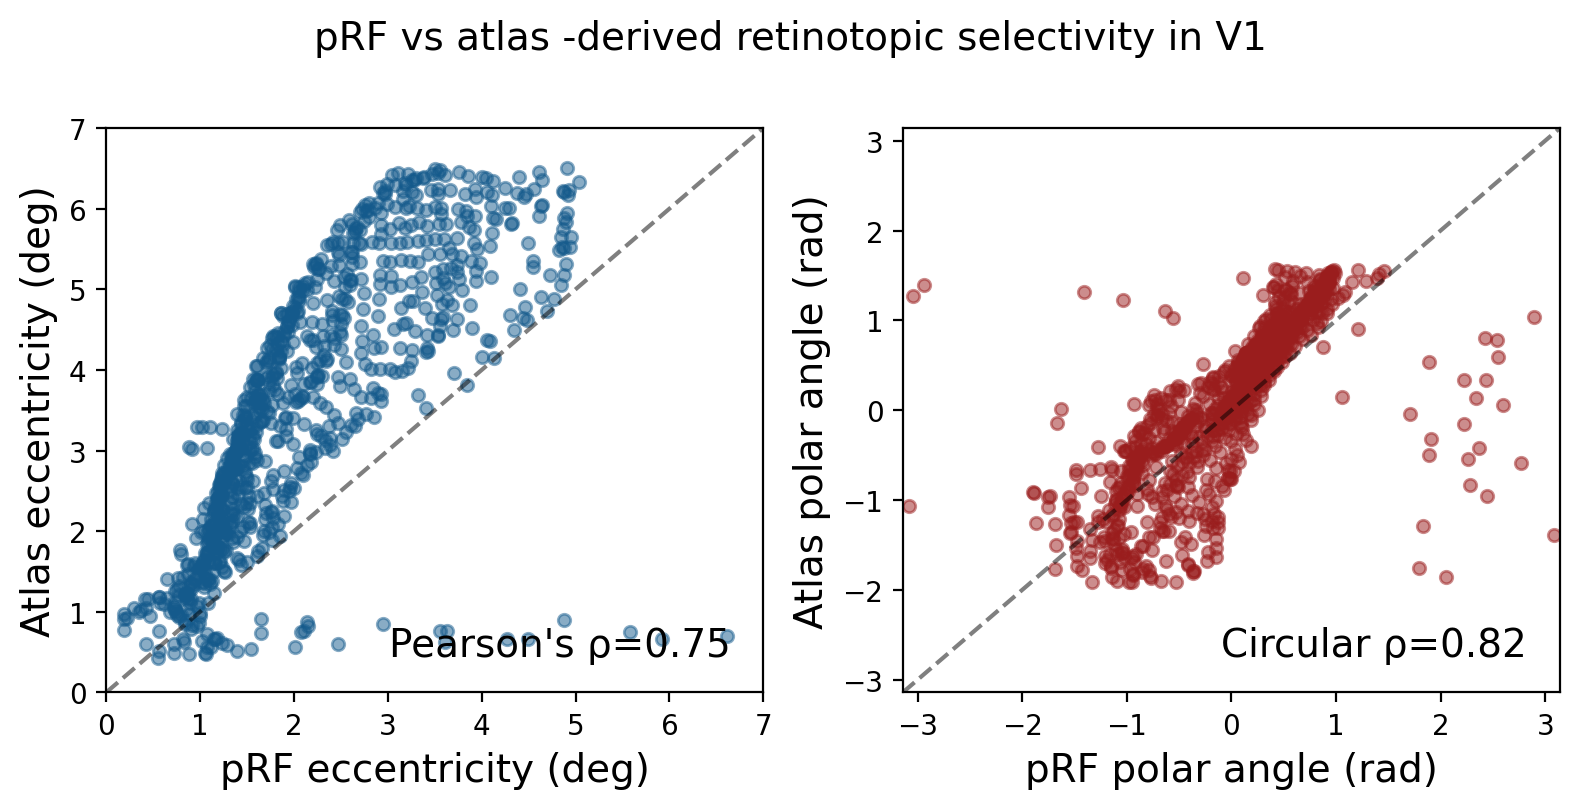

In [34]:

# Map correlations
from scipy.stats import pearsonr
from pingouin import circ_corrcl

mask = sub_source_mask

ecc_pRF = ecc_map[mask]
pol_pRF = polar_map[mask]
ecc_atlas = benson_eccen[mask] 
pol_atlas = np.deg2rad(benson_polar[mask] *2)-np.pi

# Compute circular correlation
corr_pol = circ_corrcl(pol_pRF, pol_atlas)
corr_pol_rho = corr_pol[0]
corr_pol_pval = corr_pol[1]

corr_ecc_rho, corr_ecc_pval = pearsonr(ecc_pRF, ecc_atlas)

print("\nPearson's rho (p-value) : ", corr_ecc_rho,'(',corr_ecc_pval,')')
print("\nCircular rho  (p-value) : ", corr_pol_rho, '(',corr_pol_pval,')')


# Scatter plots
fig, (ax_ecc, ax_pol) = plt.subplots(1, 2, figsize=(8, 4), dpi=200)

alpha = 0.5
scatter_size = 20

fig.suptitle(f'pRF vs atlas -derived retinotopic selectivity in V1', fontsize=14, y=1)

ecc_color = "#145A8C"  
pol_color = "#9A1D1D"  

# Eccentricity scatter plot
ax_ecc.scatter(ecc_pRF, ecc_atlas, alpha=alpha, s=scatter_size, c=ecc_color)
max_ecc = np.ceil(max(ecc_pRF.max(), ecc_atlas.max()))
ax_ecc.plot([0, max_ecc], [0, max_ecc], 'k--', alpha=0.5)
ax_ecc.set_xlim(0, max_ecc)
ax_ecc.set_ylim(0, max_ecc)
ax_ecc.set_xlabel('pRF eccentricity (deg)', fontsize=14)
ax_ecc.set_ylabel('Atlas eccentricity (deg)', fontsize=14)
ax_ecc.text(0.95, 0.05, f"Pearson's ρ={corr_ecc_rho:.2f}", 
            ha='right', va='bottom', fontsize=14, transform=ax_ecc.transAxes)

# Polar angle scatter plot
ax_pol.scatter(pol_pRF, pol_atlas, alpha=alpha, s=scatter_size, c=pol_color)
ax_pol.plot([-np.pi, np.pi], [-np.pi, np.pi], 'k--', alpha=0.5)
ax_pol.set_xlim(-np.pi, np.pi)
ax_pol.set_ylim(-np.pi, np.pi)
ax_pol.set_xlabel('pRF polar angle (rad)', fontsize=14)
ax_pol.set_ylabel('Atlas polar angle (rad)', fontsize=14)
ax_pol.text(0.95, 0.05, f"Circular ρ={corr_pol_rho:.2f}", 
            ha='right', va='bottom', fontsize=14, transform=ax_pol.transAxes)

plt.tight_layout()
plt.show()
